In [1]:
suppressMessages(library(RCurl)) # for downloading files
suppressMessages(library(dplyr)) # data manipulation
suppressMessages(library(grid)) # for textGrob
suppressMessages(library(gridExtra)) # for arranging plots
suppressMessages(library(ggplot2)) # plotting
suppressMessages(library(data.table)) # loading csv files
suppressMessages(library(RColorBrewer)) # for ColorBrewer palettes

Setting input paths and output paths. An error will be raised if the file does not exists

In [2]:
# Function to set file paths and check their existence
set_file_path <- function(file_name) {
  file_path <- file.path("./results", file_name)
  if (!file.exists(file_path)) {
    stop(paste("The file", file_name, 
    "does not exist. Please run the notebook to generate the required output files."))
  }
  return(file_path)
}

# Setting file paths using the function
dmso_pairwise_scores <- set_file_path("final_pairwise_scores.csv")
trt_pairwise_scores <- set_file_path("final_trt_pairwise_scores.csv")
replicate_pairwise_scores <- set_file_path("final_replicate_pairwise_scores.csv")
consensus_scores <- set_file_path("final_dmso_consensus_pairwise_scores.csv")

# creating a figures directory in the results folder
plot_output_dir <- "./results/figures"
if (!dir.exists(plot_output_dir)) {
  dir.create(plot_output_dir, recursive = TRUE)
}


loading the pairwise compare scores

In [3]:
dmso_pairwise_df <- fread(dmso_pairwise_scores) # loads the dmso pairwise scores
consensus_dmso_df <- fread(consensus_scores) # loads the dmso consensus scores
trt_pairwise_df <- fread(trt_pairwise_scores) # loads the trt pairwise scores
replicate_pairwise_df <- fread(replicate_pairwise_scores) # loads the replicate pairwise scores

## Creating a histogram of the pairwise compare scores with only controls

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


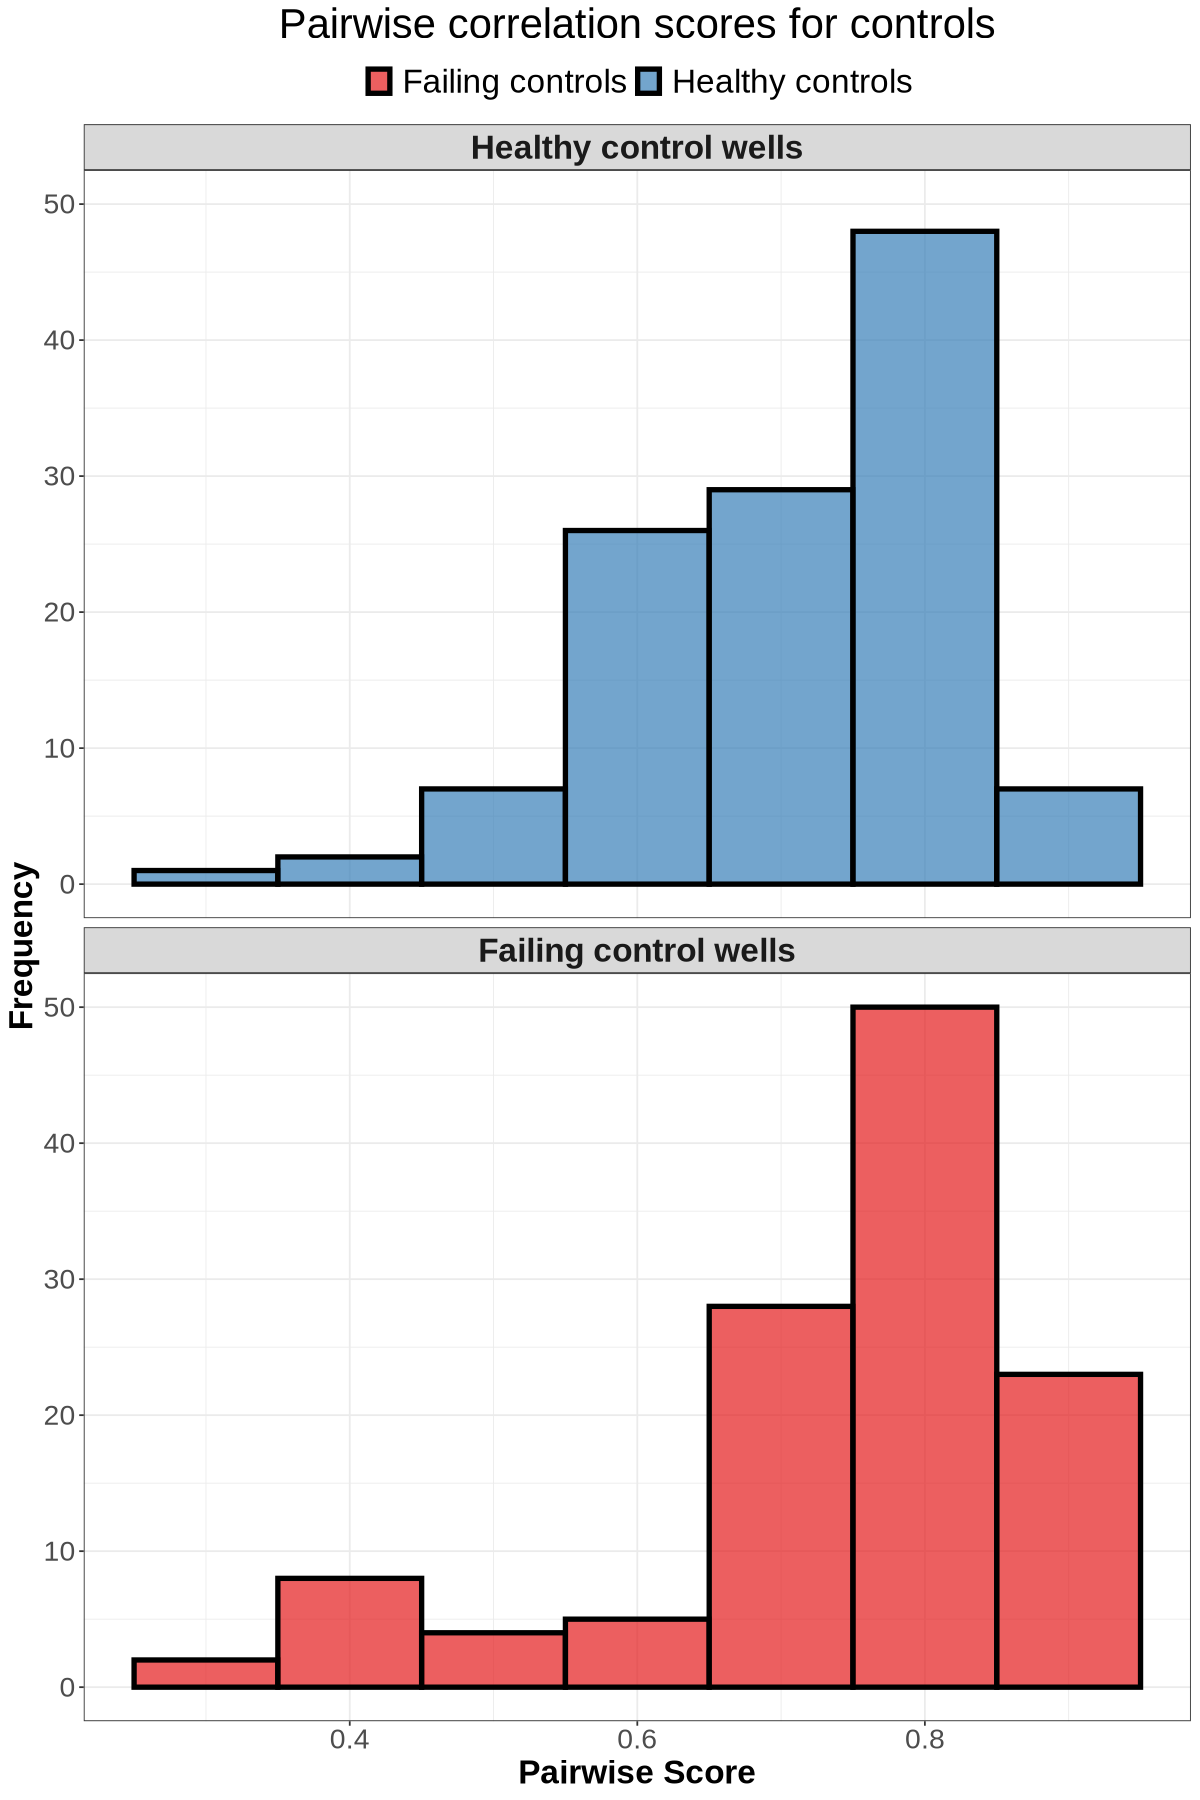

In [4]:
# setting the figure size for the notebook
width <- 10
height <- 15
options(repr.plot.width = width ,repr.plot.height = height)

# creating a histogram of the dmso pairwise scores using ggplot2 while
# creating a facet using the Metadata_treatment column and assigning colors
dmso_pairwise_histogram <- ggplot(dmso_pairwise_df, aes(x = pearsons_correlation, fill = Metadata_treatment)) +
     geom_histogram(binwidth = 0.1, color = "black", size = 1.5, alpha = 0.7) +
     
     # reordering Metadata_treatment to ensure "Healthy" is on top
     facet_wrap(~factor(Metadata_treatment, levels = c("DMSO-positive", "DMSO-negative")), 
                ncol = 1,  # Arrange facets from top to bottom
                labeller = as_labeller(c(
                     "DMSO-negative" = "Failing control wells",
                     "DMSO-positive" = "Healthy control wells"
                ))) +
     
     # setting the color for the histogram bars
     # using the Metadata_treatment column to assign colors
     scale_fill_manual(
          values = brewer.pal(3, "Set1")[1:2], # using ColorBrewer palette
          labels = c("DMSO-negative" = "Failing controls", "DMSO-positive" = "Healthy controls")
     ) +

     # adding labels and titles
     labs(
          title = "Pairwise correlation scores for controls",
          x = "Pairwise Score",
          y = "Frequency"
     ) +

     # setting the theme for the plot and 
     # adjusting the legend position and text size
     theme_bw() +
     theme(
          legend.position = "top",
          legend.title = element_blank(),
          legend.text = element_text(size = 20),
          axis.text.x = element_text(size = 17),
          axis.text.y = element_text(size = 17),
          axis.title.x = element_text(size = 20, face = "bold"),
          axis.title.y = element_text(size = 20, face = "bold"),
          plot.title = element_text(hjust = 0.5, size = 25),
          strip.text = element_text(size = 20, face = "bold")
     ) 

# save plot into figures directory
ggsave(
     filename = file.path(plot_output_dir, "dmso_pairwise_histogram.png"),
     plot = dmso_pairwise_histogram,
     width = 15,
     height = 10,
     dpi = 300
)

dmso_pairwise_histogram


## Heatmaps of pairwise similarity scores compared to controls

Creating a heatmap to visualize the pairwise correlation scores of controls, highlighting the individual comparison scores for each control.

In [5]:
# only select rows where Metadata_trement is "DMSO-positive" 
healthy_dmso_pairwise_df <- dmso_pairwise_df %>%
     filter(Metadata_treatment == "DMSO-positive") %>%
     select(pearsons_correlation, Metadata_treatment, plate_well_0, plate_well_1) %>%
     arrange(desc(pearsons_correlation))

# only select rows where Metadata_trement is "DMSO-negative"
failing_dmso_pairwise_df <- dmso_pairwise_df %>%
     filter(Metadata_treatment == "DMSO-negative") %>%
     select(pearsons_correlation, Metadata_treatment, plate_well_0, plate_well_1) %>%
     arrange(desc(pearsons_correlation))

TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (3-3,1-1) arrange      gtable[layout]
3 3 (1-1,1-1) arrange text[GRID.text.361]

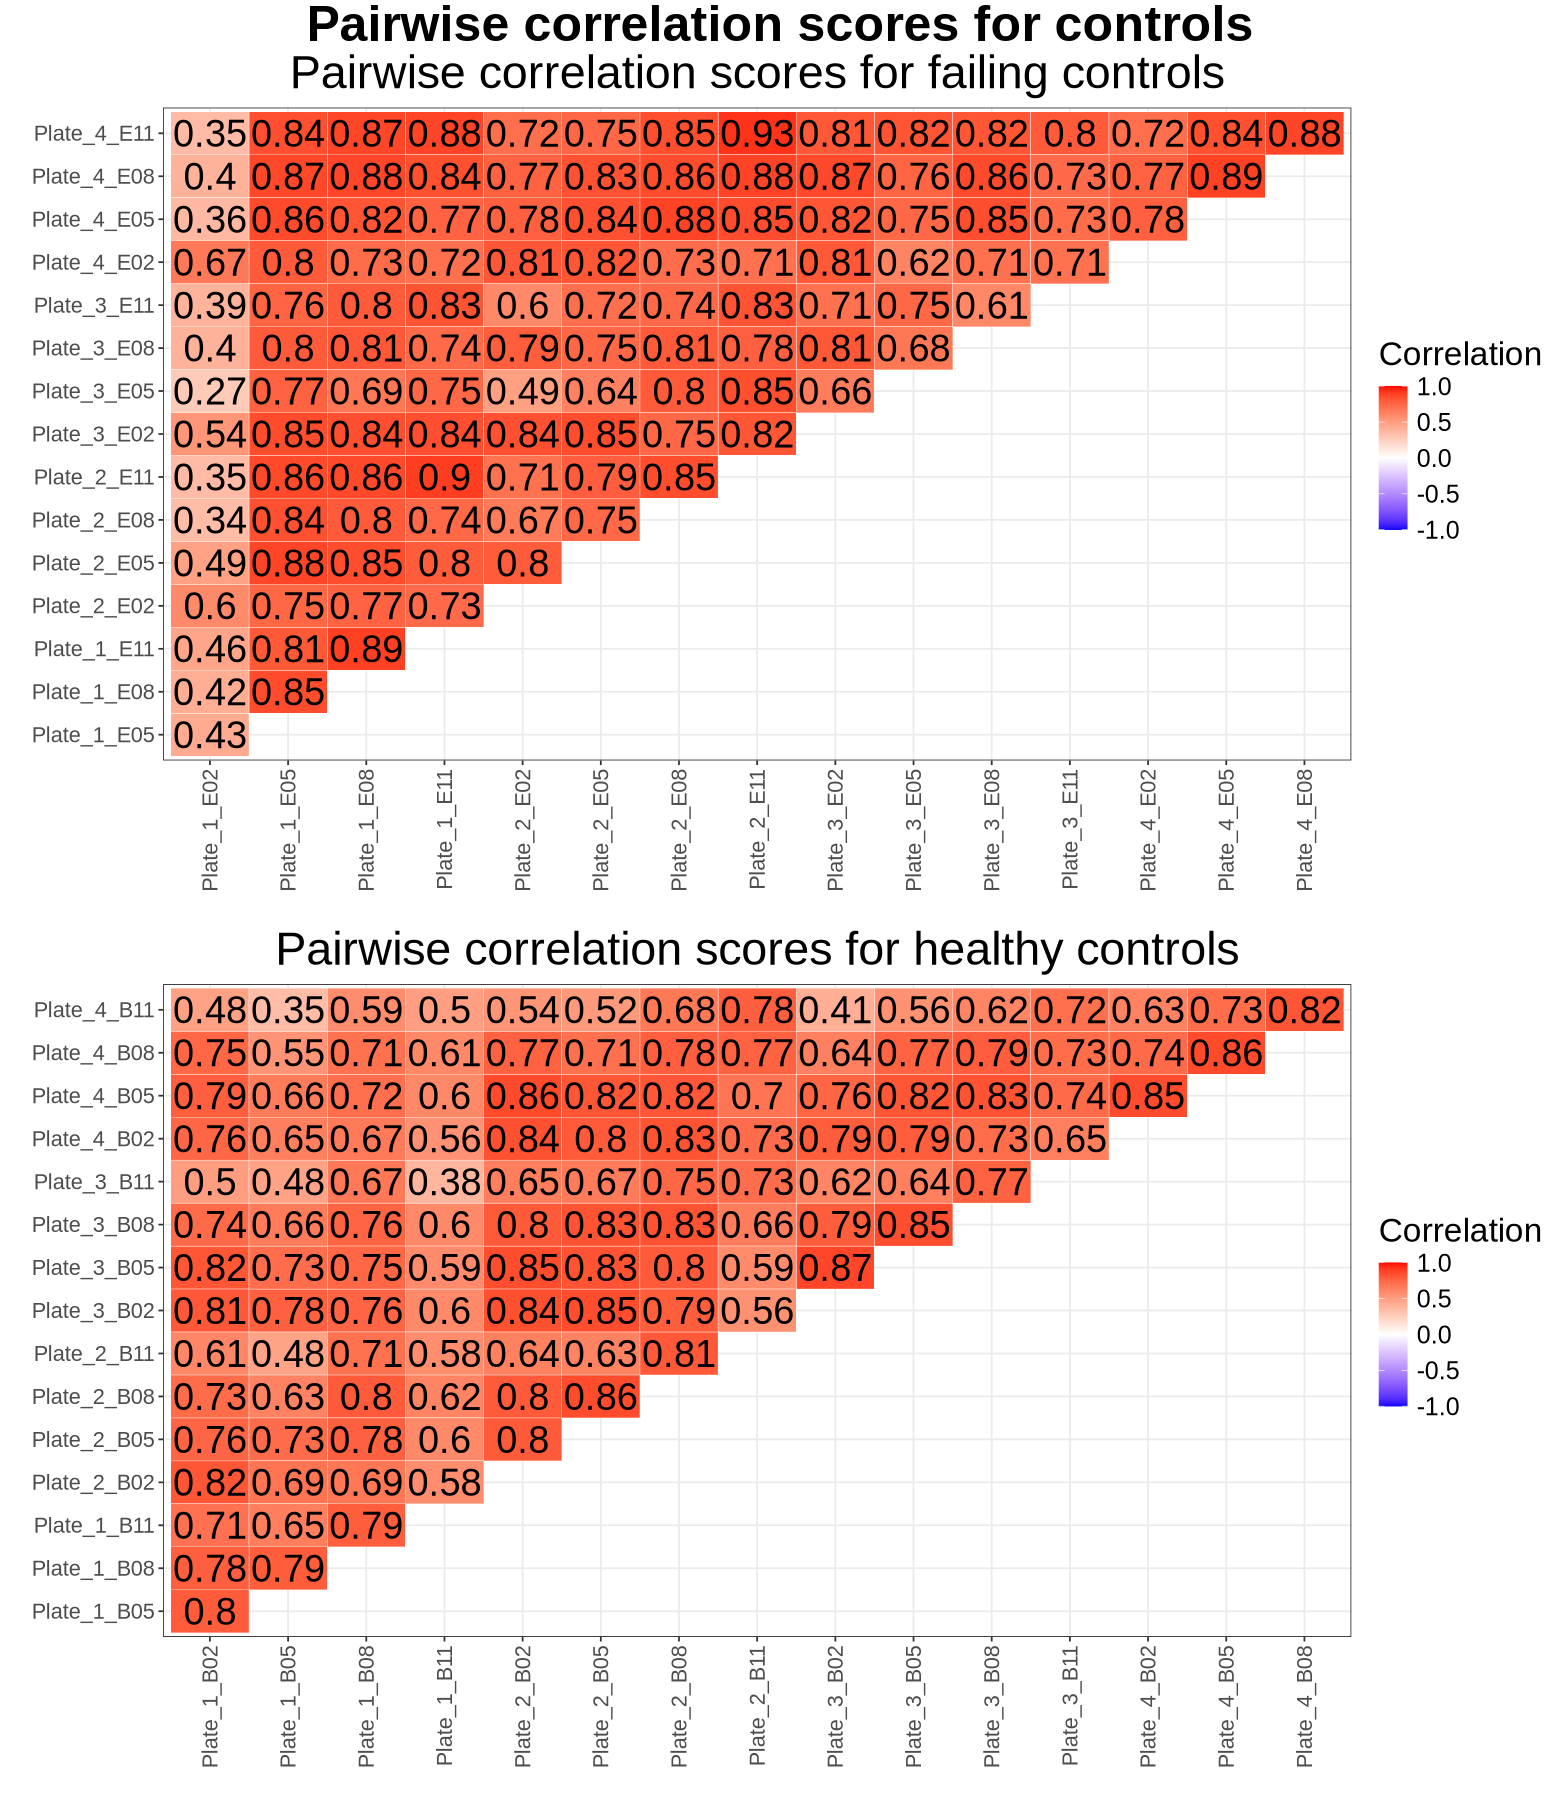

In [6]:
# update the option for display figure in notebook
options(repr.plot.width = 13, repr.plot.height = 15)

# create a heatmap of the failing dmso pairwise scores with annotations
failing_dmso_pairwise_heatmap <- ggplot(failing_dmso_pairwise_df, aes(x = plate_well_0, y = plate_well_1)) +
     geom_tile(aes(fill = pearsons_correlation), color = "white") +
     geom_text(aes(label = round(pearsons_correlation, 2)), size = 8) +  
     scale_fill_gradient2(
          low = "blue", mid = "white", high = "red", midpoint = 0, limits = c(-1, 1),
          name = "Correlation"  # Updated legend title
     ) +
     labs(
          title = "Pairwise correlation scores for failing controls",
          x = "",
          y = ""
     ) +
     theme_bw() +
     theme(
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 13),  
          axis.text.y = element_text(angle = 0, hjust = 1, size = 13),  
          plot.title = element_text(hjust = 0.5, size = 28),
          legend.text = element_text(size = 15), 
          legend.title = element_text(size = 20, margin = margin(b = 10)) 
     )

# create a heatmap of the healthy dmso pairwise scores with annotations
dmso_pairwise_heatmap <- ggplot(healthy_dmso_pairwise_df, aes(x = plate_well_0, y = plate_well_1)) +
     geom_tile(aes(fill = pearsons_correlation), color = "white") +
     geom_text(aes(label = round(pearsons_correlation, 2)), size = 8) +  
     scale_fill_gradient2(
          low = "blue", mid = "white", high = "red", midpoint = 0, limits = c(-1, 1),
          name = "Correlation"  # Updated legend title
     ) +
     labs(
          title = "Pairwise correlation scores for healthy controls",
          x = "",
          y = ""
     ) +
     theme_bw() +
     theme(
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 13),  
          axis.text.y = element_text(angle = 0, hjust = 1, size = 13),  
          plot.title = element_text(hjust = 0.5, size = 28),
          legend.text = element_text(size = 15), 
          legend.title = element_text(size = 20, margin = margin(b = 10)) 
     )
     
# now merge the heatmaps into one figures 
heatmap_plot = grid.arrange(
     failing_dmso_pairwise_heatmap,
     dmso_pairwise_heatmap,
     ncol = 1,
     top = textGrob("Pairwise correlation scores for controls", gp = gpar(fontsize = 30, fontface = "bold"))
)

# now save the heatmap plot into the figures directory
ggsave(
     filename = file.path(plot_output_dir, "dmso_pairwise_heatmap.png"),
     plot = heatmap_plot,
     width = 15,
     height = 20,
     dpi = 300
)

heatmap_plot

Creating a heatmap to visualize the pairwise correlation scores of consensus profiles of the controls.

In [7]:
# updating column names for the consensus scores
consensus_dmso_df <- consensus_dmso_df %>%
    rename(
        metadata_plate_0 = Metadata_plate_name__posthoc_group0,
        metadata_plate_1 = Metadata_plate_name__posthoc_group1
    )

# separating based on metadata_treatment (DMSO-positive or DMSO-negative)
healthy_dmso_consensus_df <- consensus_dmso_df %>%
    filter(Metadata_treatment == "DMSO-positive") %>%
    select(pearsons_correlation, Metadata_treatment, metadata_plate_0, metadata_plate_1) %>%
    arrange(desc(pearsons_correlation))
failing_dmso_consensus_df <- consensus_dmso_df %>%
    filter(Metadata_treatment == "DMSO-negative") %>%
    select(pearsons_correlation, Metadata_treatment, metadata_plate_0, metadata_plate_1) %>%
    arrange(desc(pearsons_correlation))

TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (3-3,1-1) arrange      gtable[layout]
3 3 (1-1,1-1) arrange text[GRID.text.463]

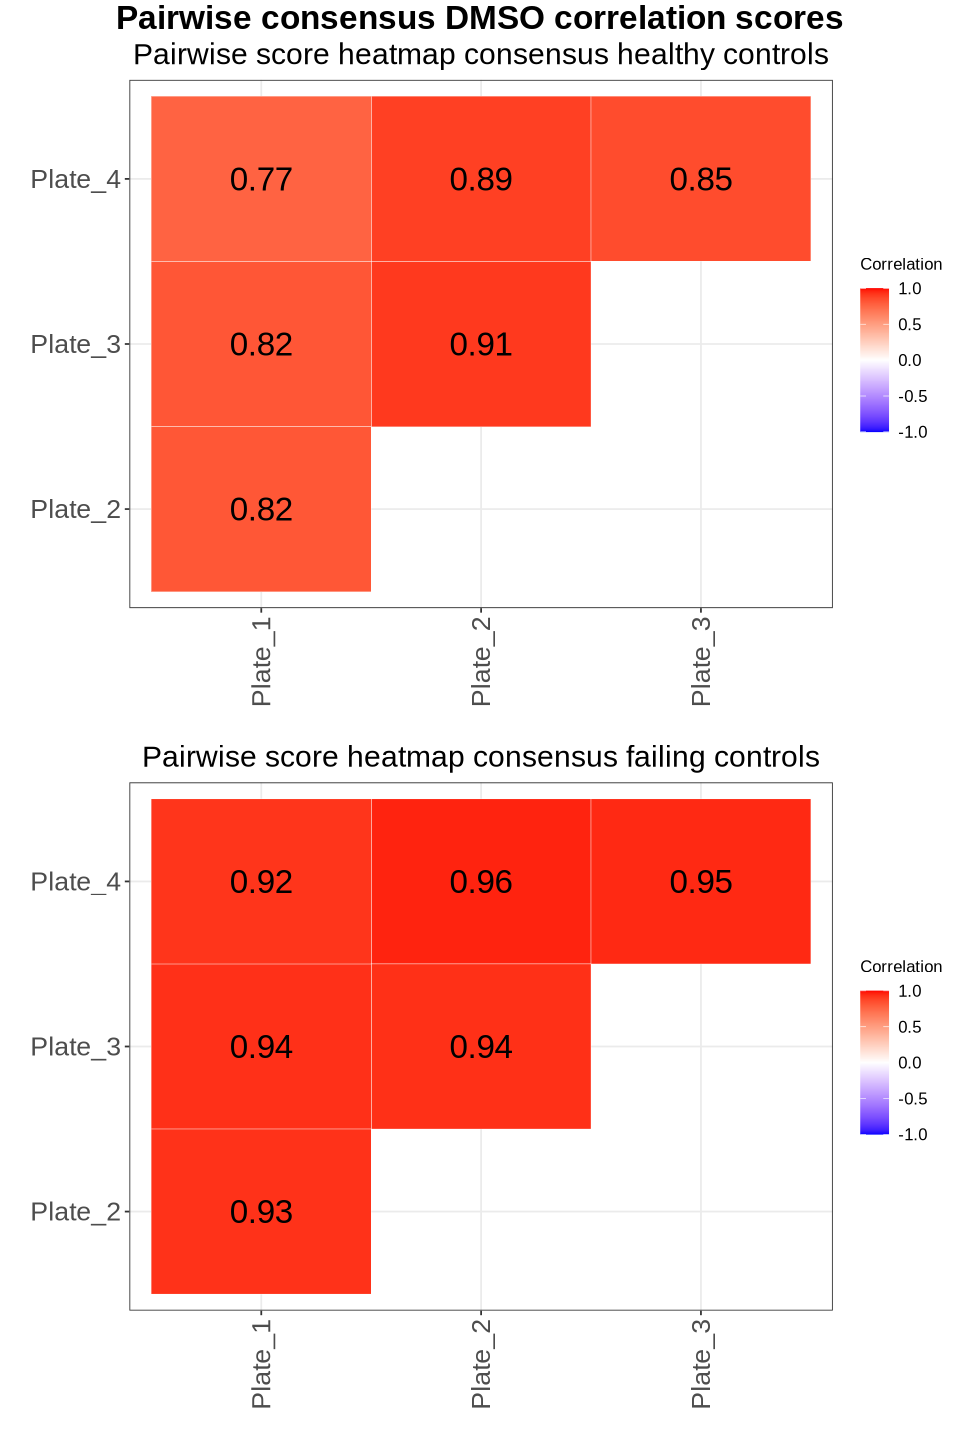

In [8]:
# Make plots show up nice in the notebook
width <- 8
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Plot1: Create the consensus health controls heatmap
health_control_consensus_heatmap <- ggplot(healthy_dmso_consensus_df, aes(x = metadata_plate_0, y = metadata_plate_1)) +
    geom_tile(aes(fill = pearsons_correlation), color = "white") +
    geom_text(aes(label = round(pearsons_correlation, 2)), size = 7) +
    scale_fill_gradient2(
        low = "blue", mid = "white", high = "red", midpoint = 0, limits = c(-1, 1), name = "Correlation"
    ) +
    labs(
        title = "Pairwise score heatmap consensus healthy controls", 
        x = "",
        y = ""
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18),  
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 16),
        axis.text.y = element_text(size = 16),
        legend.text = element_text(size = 10),  
        legend.title = element_text(size = 10, margin = margin(b = 10))
    )

# Plot2: Create the consensus failing controls heatmap
failing_dmso_consensus_heatmap <- ggplot(failing_dmso_consensus_df, aes(x = metadata_plate_0, y = metadata_plate_1)) +
    geom_tile(aes(fill = pearsons_correlation), color = "white") +
    geom_text(aes(label = round(pearsons_correlation, 2)), size = 7) +
    scale_fill_gradient2(
        low = "blue", mid = "white", high = "red", midpoint = 0, limits = c(-1, 1), name = "Correlation"
    ) +
    labs(
        title = "Pairwise score heatmap consensus failing controls", 
        x = "", 
        y = ""
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18), 
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 16),
        axis.text.y = element_text(size = 16),
        legend.text = element_text(size = 10),
        legend.title = element_text(size = 10, margin = margin(b = 10))
    )

# Wrap both plots in a grid
consensus_dmso_pairwise_heatmap <- grid.arrange(
    health_control_consensus_heatmap,
    failing_dmso_consensus_heatmap,
    ncol = 1,
    top = textGrob("Pairwise consensus DMSO correlation scores", gp = gpar(fontsize = 20, fontface = "bold"))
)

# save the heatmap plot into the figures directory
ggsave(
    filename = file.path(plot_output_dir, "consensus_dmso_pairwise_heatmap.png"),
    plot = consensus_dmso_pairwise_heatmap,
    width = width,
    height = height,
    dpi = 400,
    bg = "white"
)

# Display the heatmap
consensus_dmso_pairwise_heatmap


## Box plot of pairwise scores between treated wells and controls (healthy vs. failing)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


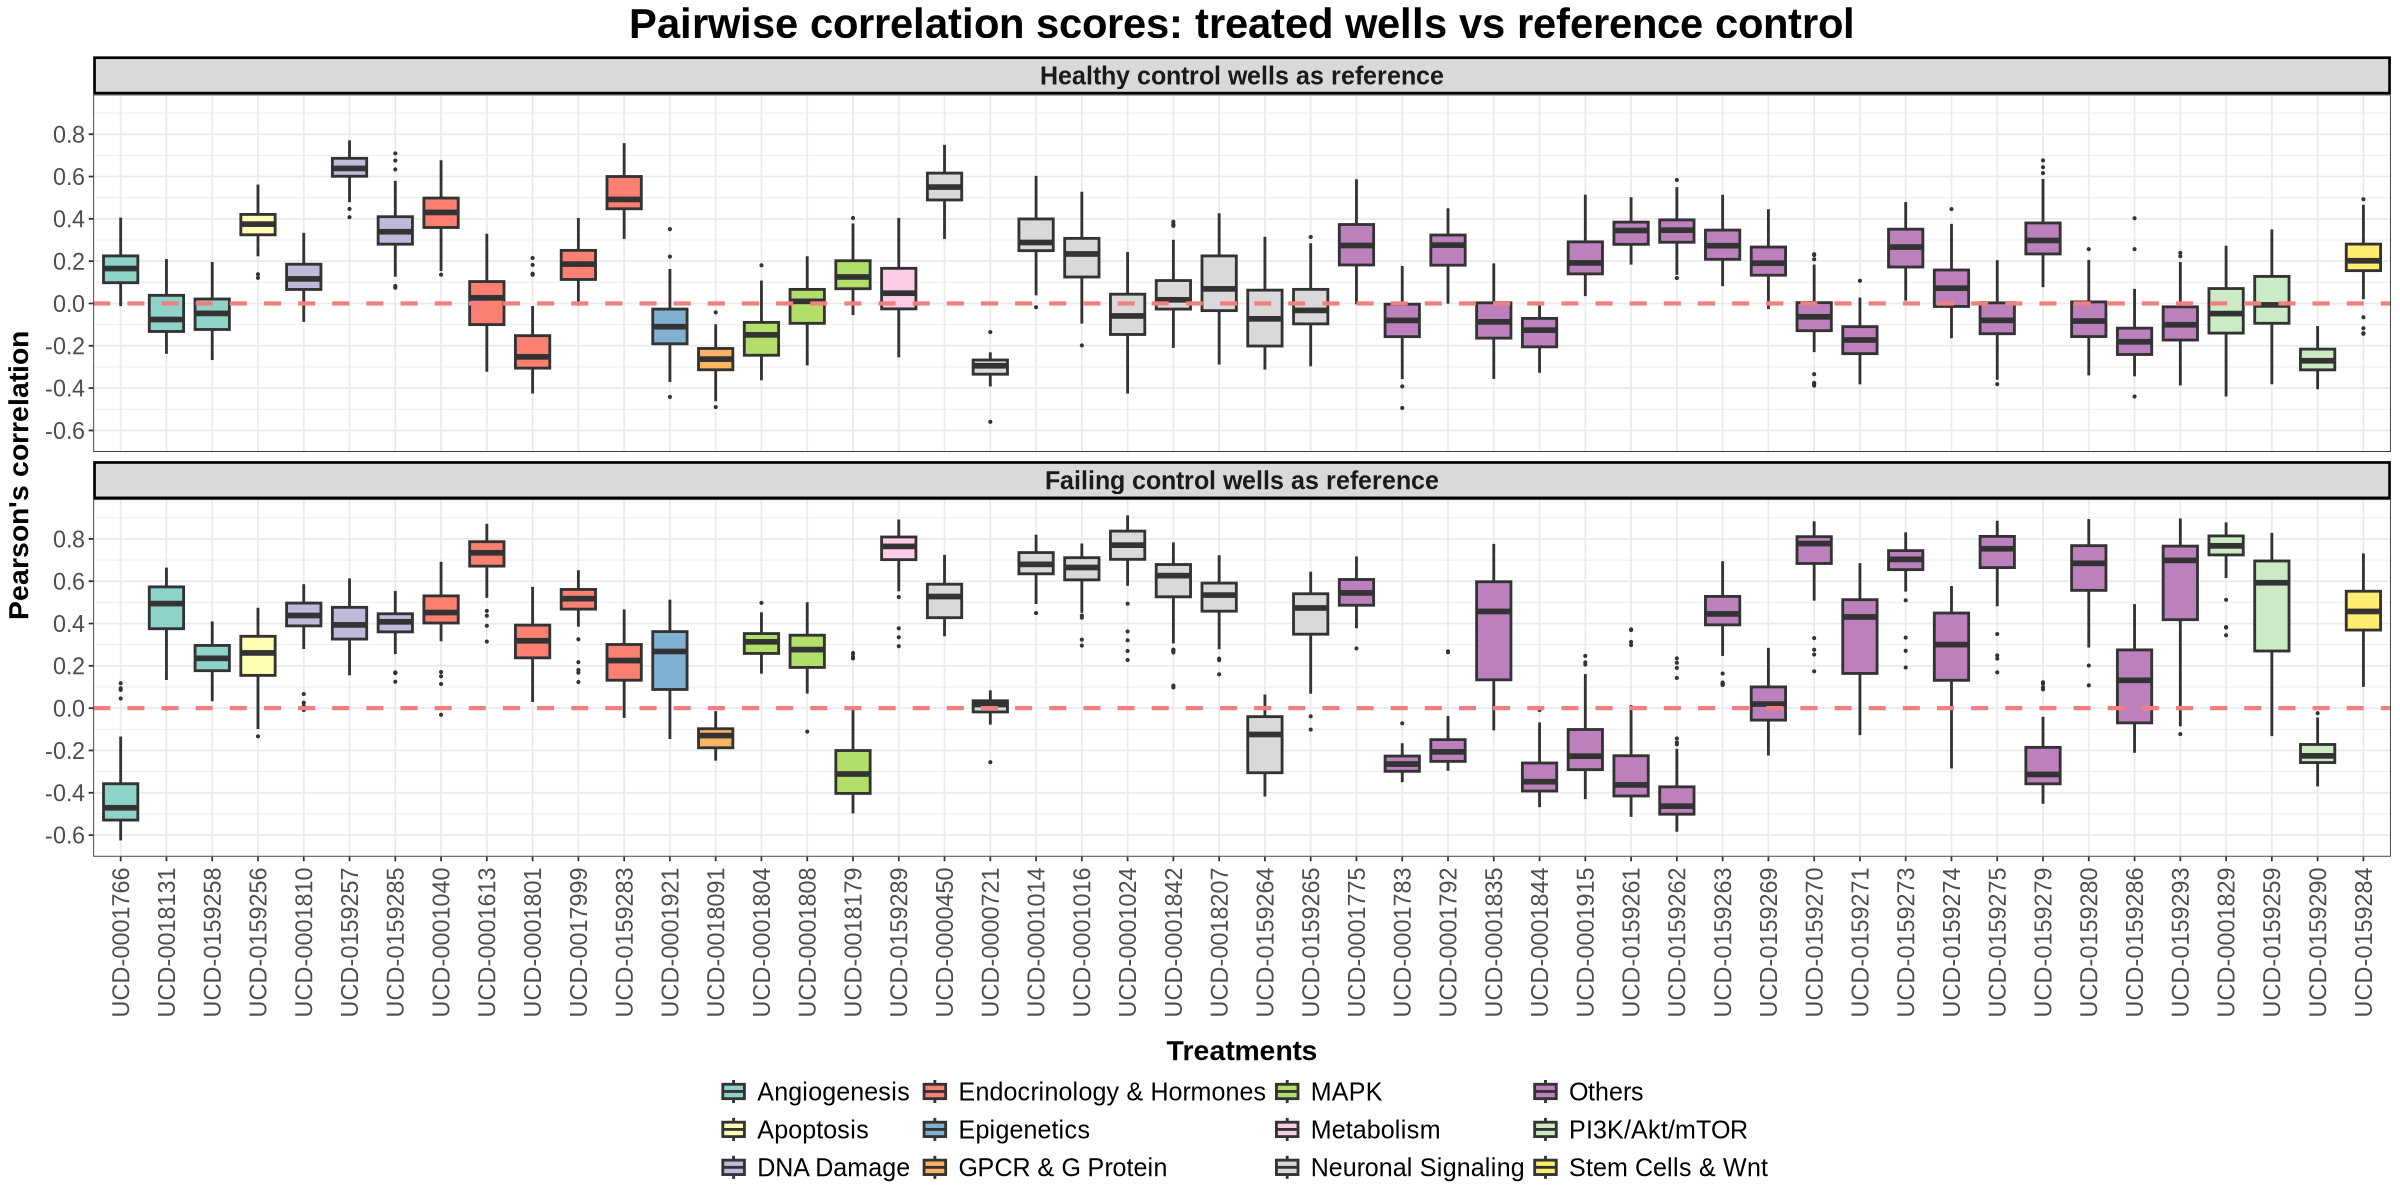

In [9]:
# Reordering the reference factor to place "Healthy" on top
trt_pairwise_df$reference <- factor(trt_pairwise_df$reference, levels = c("Healthy", "Failing"))

# Reordering Metadata_treatment based on the order of Metadata_Pathway
trt_pairwise_df$Metadata_treatment <- factor(trt_pairwise_df$Metadata_treatment, 
                                             levels = unique(trt_pairwise_df$Metadata_treatment[order(trt_pairwise_df$Metadata_Pathway)]))

# setting figure size for the notebook
width <- 20
height <- 10
options(repr.plot.width = width ,repr.plot.height = height)

# creating a boxplot of the dataset using ggplot2
pairwise_score_boxplot <- ggplot(trt_pairwise_df, aes(x = Metadata_treatment, y = pearsons_correlation, fill = Metadata_Pathway)) +
    geom_boxplot(outlier.size = 0.5, linewidth = .8) +  # Increased edge thickness of the boxplot
    
    # adding a light red horizontal line at y = 0
    geom_hline(yintercept = 0, color = "lightcoral", linetype = "dashed", linewidth = 1.2) +
    
    # setting up the facet for the boxplot
    # using the reference column to create separate boxplots
    facet_wrap(~reference, ncol = 1, labeller = as_labeller(c(
        "Healthy" = "Healthy control wells as reference",
        "Failing" = "Failing control wells as reference"
    ))) +
    
    # setting the color for the boxplot bars
    # using the Metadata_Pathway column to assign colors
    scale_fill_brewer(palette = "Set3") +

    # adding labels and titles
    labs(
        title = "Pairwise correlation scores: treated wells vs reference control",
        x = "Treatments",
        y = "Pearson's correlation"
    ) +

    # setting the y-axis ticks with separation of 0.2
    scale_y_continuous(breaks = seq(-1, 1, by = 0.2)) +

    # setting the theme for the plot and 
    # adjusting the legend position and text size
    theme_bw() +
    theme(
        legend.position = "bottom",
        legend.title = element_blank(),
        legend.text = element_text(size = 15),
        axis.text.x = element_text(size = 14, angle = 90, vjust = .5), 
        axis.text.y = element_text(size = 14), 
        axis.title.x = element_text(size = 17, face = "bold", vjust = -1.7),
        axis.title.y = element_text(size = 17, face = "bold"),
        plot.title = element_text(hjust = 0.5, size = 25,face = "bold"),
        strip.text = element_text(size = 15, face = "bold"),
        strip.background = element_rect(color = "black", size = 1.5) 
    ) 

# save plot into figures directory
ggsave(
    filename = file.path(plot_output_dir, "trt_pairwise_boxplot.png"),
    plot = pairwise_score_boxplot,
    width = 20,
    height = 10,
    dpi = 300
)

pairwise_score_boxplot

## Creating a scatter plot of the pairwise controls between replicates

In [10]:
# data manipulation to create a new column for the compared combinations
# updating the plate names to only have the numeric value
# creating a new column for the compared combinations
replicate_pairwise_df <- replicate_pairwise_df %>%
  mutate(
    plate_name_0 = gsub("Plate_", "", plate_name_0),
    plate_name_1 = gsub("Plate_", "", plate_name_1),
    compared_combinations = paste0(
      Metadata_treatment, "_Plates_", plate_name_0, "_", plate_name_1
    )
  )
head(replicate_pairwise_df)

pearsons_correlation,Metadata_treatment,plate_name_0,plate_name_1,compared_combinations
<dbl>,<chr>,<chr>,<chr>,<chr>
0.8598942,UCD-0000450,1,2,UCD-0000450_Plates_1_2
0.8220859,UCD-0000450,1,3,UCD-0000450_Plates_1_3
0.8666370,UCD-0000450,1,4,UCD-0000450_Plates_1_4
0.8121859,UCD-0000450,2,3,UCD-0000450_Plates_2_3
0.7955506,UCD-0000450,2,4,UCD-0000450_Plates_2_4
0.7956993,UCD-0000450,3,4,UCD-0000450_Plates_3_4


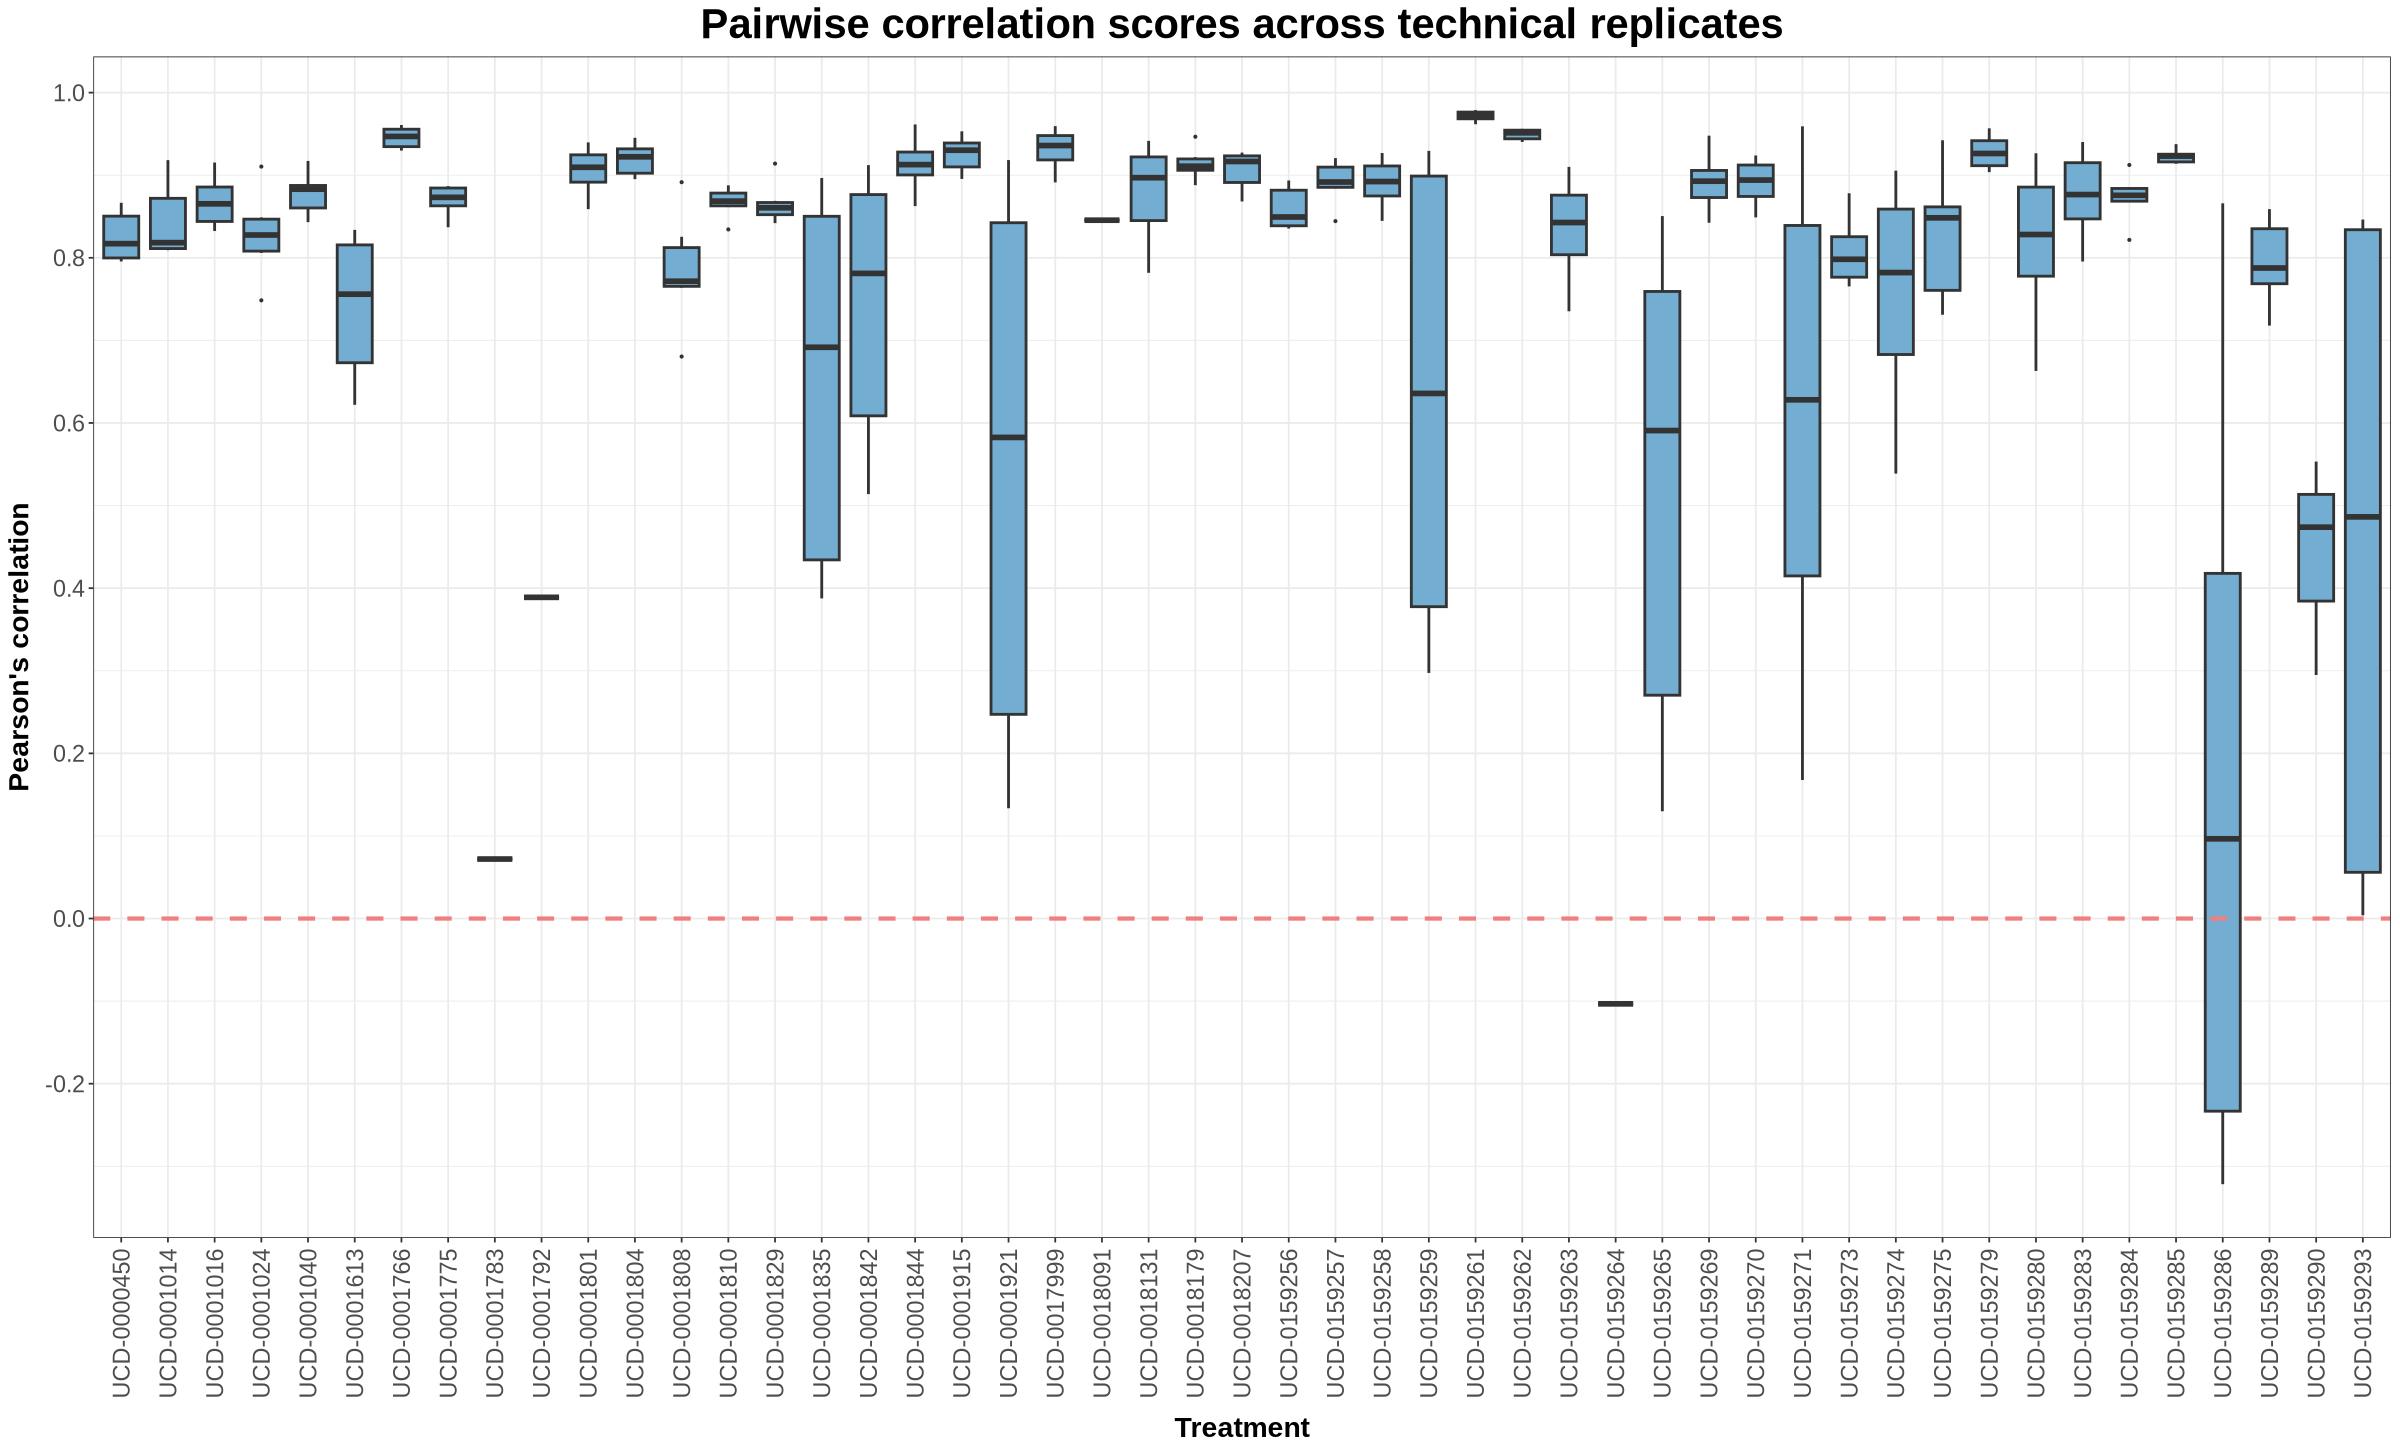

In [11]:
# Set figure size in notebook
width <- 20
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Reorder treatments (optional: based on some logic)
replicate_pairwise_df$Metadata_treatment <- factor(replicate_pairwise_df$Metadata_treatment,
                           levels = unique(replicate_pairwise_df$Metadata_treatment))

# Create styled boxplot
replicate_pairwise_plot <- ggplot(replicate_pairwise_df, aes(x = Metadata_treatment, y = pearsons_correlation)) +
  geom_boxplot(outlier.size = 0.5, linewidth = 0.8, fill = "#73add1") +
  
  geom_hline(yintercept = 0, color = "lightcoral", linetype = "dashed", linewidth = 1.2) +

  # Adjust axis and labels
  labs(
  title = "Pairwise correlation scores across technical replicates",
  x = "Treatment",
  y = "Pearson's correlation"
  ) +

  scale_y_continuous(breaks = seq(-1, 1, by = 0.2)) +

  # Match styling
  theme_bw() +
  theme(
  legend.position = "none",
  axis.text.x = element_text(size = 14, angle = 90, vjust = 0.5),
  axis.text.y = element_text(size = 14),
  axis.title.x = element_text(size = 17, face = "bold", vjust = -1.0),
  axis.title.y = element_text(size = 17, face = "bold"),
  plot.title = element_text(hjust = 0.5, size = 25, face = "bold")
  )

# Save to figures directory if needed
ggsave(
  filename = file.path(plot_output_dir, "replicate_pairwise_boxplot.png"),
  plot = replicate_pairwise_plot,
  width = width,
  height = height,
  dpi = 300
)

replicate_pairwise_plot
